# Combining Different Models For Ensemble Learning

## Learning With Ensembles

The goal of **ensemble methods** is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone. For example, assuming  that we collect predictions from 10 experts, ensemble methods would allow us to strategically combine those predictions by the 10 experts to come up with a prediction that was more robust and accurate than the predictions by each indiivdual expert.

**Majority voting** means that we select the class label that has been predicted by the majority of classifiers. The equivalent for multiclass setting is called **plurality voting**.

![Alt text](../images/22.png)

## Combining Classifiers Via Majority Vote

### Implementing a Simple Majotity Vote Classifier

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal; '
                             f'got {len(self.weights)} weights, {len(self.classifiers)} classifiers')

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = [clone(clf).fit(X, self.lablenc_.transform(y)) for clf in self.classifiers]
        
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(
                np.bincount(x.astype(int), weights=self.weights if self.weights else None)
            ), axis=1, arr=predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = []
        for clf in self.classifiers_:
            if hasattr(clf, "predict_proba"):
                probas.append(clf.predict_proba(X))
            else:
                raise AttributeError(f"Classifier {clf.__class__.__name__} does not support predict_proba")
        probas = np.asarray(probas)
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        out = super().get_params(deep=False)
        if deep:
            for name, step in self.named_classifiers.items():
                out.update((f"{name}__{key}", value) for key, value in step.get_params(deep=True).items())
        return out


### Using The Majority Voting Principle To Make Predictions

In [27]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Use pipelines to ensure proper preprocessing
pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe2 = Pipeline([('clf', clf2)])  # Wrapping for consistency
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])

# Classifier labels
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

# Perform cross-validation for individual classifiers
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [30]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, pipe2, pipe3])
clf_labels.append('Majority voting')
all_clf = [pipe1, pipe2, pipe3, mv_clf]

# Evaluate Majority Voting Classifier
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/utils/_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: MajorityVoteClassifier should either be a

### Evaluating and Tuning The Ensemble Classifier

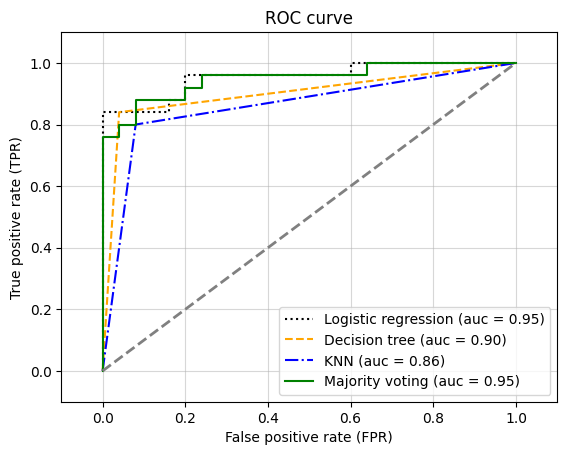

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
linestyle='--',
color='gray',
linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve')
plt.show()

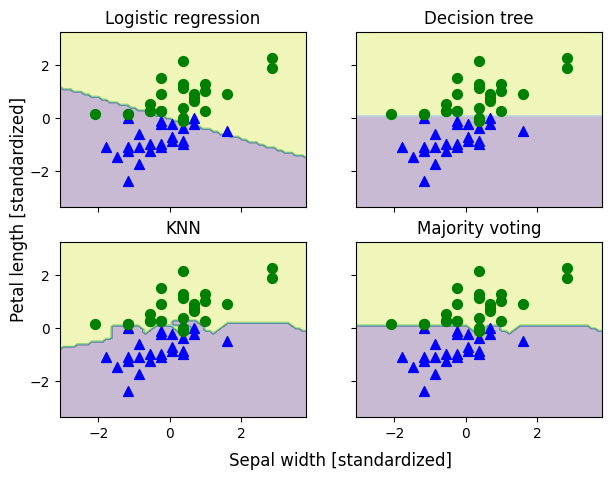

In [32]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                    X_train_std[y_train==0, 1],
                                    c='blue',
                                    marker='^',
                                    s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                    X_train_std[y_train==1, 1],
                                    c='green',
                                    marker='o',
                                    s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
        s='Sepal width [standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
        s='Petal length [standardized]',
        ha='center', va='center',
        fontsize=12, rotation=90)
plt.show()

In [33]:
mv_clf.get_params()

{'classifiers': [Pipeline(steps=[('sc', StandardScaler()),
                  ('clf', LogisticRegression(C=0.001, random_state=1))]),
  Pipeline(steps=[('clf',
                   DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                          random_state=0))]),
  Pipeline(steps=[('sc', StandardScaler()),
                  ('clf', KNeighborsClassifier(n_neighbors=1))])],
 'vote': 'classlabel',
 'weights': None,
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ('clf', LogisticRegression(C=0.001, random_state=1))],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,

## Bagging - Building an Ensemble of Classifiers From Bootstrap Samples

Bagging is an ensemble learning technique that is closely related to the MajorityVoteClassifier that we implemented in the previous section. However, instead of using hte same training dataset to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training dataset, which is why bagging is also known as *bootstrap aggregating*.

![Alt text](../images/23.png)

In simple terms, bagging first requires X bootstrap samples, each sample is fit to a classifier model which returns its predictions and the final label is chosen by majority voting.

### Applying Bagging to Classify Examples in the Wine Dataset

In [35]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                        'machine-learning-databases/'
                        'wine/wine.data',
                        header=None)

df_wine.columns = ['Class label', 'Alcohol',
                    'Malic acid', 'Ash',
                    'Alcalinity of ash',
                    'Magnesium', 'Total phenols',
                    'Flavanoids', 'Nonflavanoid phenols',
                    'Proanthocyanins',
                    'Color intensity', 'Hue',
                    'OD280/OD315 of diluted wines',
                    'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [38]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                                random_state=1,
                                max_depth=None)
bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [39]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [40]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies ' f'{bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


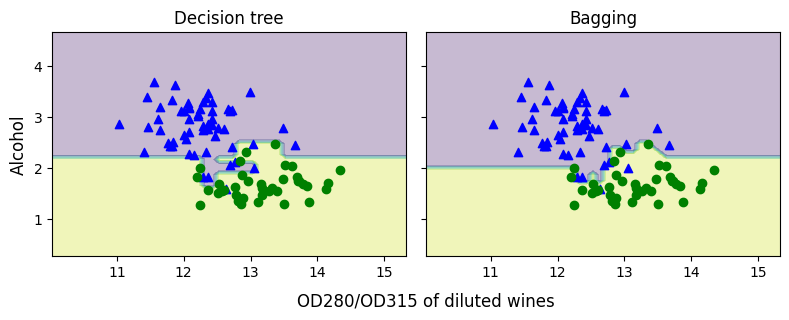

In [41]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                        X_train[y_train==0, 1],
                        c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                        X_train[y_train==1, 1],
                        c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
        s='OD280/OD315 of diluted wines',
        ha='center',
        va='center',
        fontsize=12,
        transform=axarr[1].transAxes)
plt.show()

## Leveraging Weak Learners Via Adaptive Boosting (AdaBoost)

In boosting, the ensemble consistd of very simple base classifiers, also referred to as **weak learners**, which often only have a slight performance advantage over random guessing. The key concept behinf boosting is to focus on training examples that are hard to classify, that is, to let the weak learners subsequently learn from misclassified training examples to improve the performance of the ensemble.

### How Adaptive Boosting Works

In contrast to bagging, the initial formulation of the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement, the original boosting procedure can be summarized in the following four key steps:

1. Draw a random subset (sample) of training examples, d1, without replacement from the training dataset, D, to train a weak learner, C1.

2. Draw a second random training subset, d2, without replacement from the training dataset and add 50 percent of the examples that were previously misclassified to train a weak learner, C2.

3. Find the training example, d3, in the training dataset, D, which C1 and C2 disagree upon, to train a third weak learner C3.

4. Combine the weak learners C1, C2 and C3 via majority voting.

Boosting can lead to a decrease in bias as well as variance compared to bagging models. In practice, however, boosting algorithms such as AdaBoost are also known for their high vairance.

In [42]:
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [43]:
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [44]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [45]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [46]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_2)

0.1527525231651947


In [47]:
weights = np.where(correct == 1,
                update_if_correct,
                update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [48]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


### Applying AdaBoost Using Scikit-learn

In [50]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                                random_state=1,
                                max_depth=1)
ada = AdaBoostClassifier(estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test accuracies 'f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


In [51]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f'AdaBoost train/test accuracies 'f'{ada_train:.3f}/{ada_test:.3f}')

AdaBoost train/test accuracies 0.968/0.917


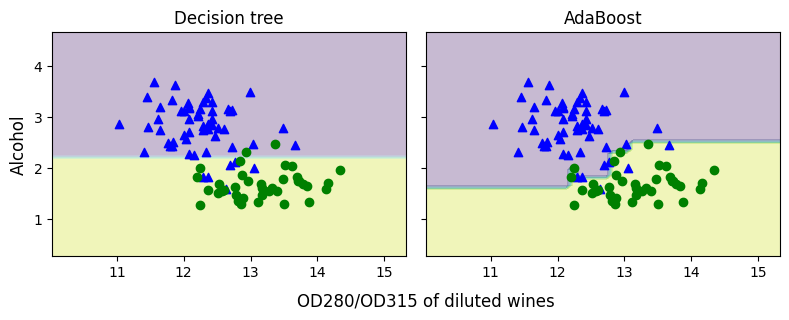

In [52]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                        X_train[y_train==0, 1],
                        c='blue',
                        marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                        X_train[y_train==1, 1],
                        c='green',
                        marker='o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
        s='OD280/OD315 of diluted wines',
        ha='center',
        va='center',
        fontsize=12,
        transform=axarr[1].transAxes)
plt.show()

## Gradient Boosting - Training an Ensemble Based on Loss Gradients

### Comparing AdaBoost With Gradient Boosting

AdaBoost trains decision tree stumps based on error of the previous decision tree stump. In particular, the errors are used to compute sample weights in each round as well as for computing a classifier weight for each decision tree stump when combining the individual stumps into an ensemble. We stop training once a maximum number of iterations is reached. 

Like AdaBoost, gradient boosting fits decision trees in an iterative fashion using prediction errors. However, gradient boosting trees are usually deeper than decision tree stumps and have tpically a maximum depth of 3 to 6. Also, in contrast to AdaBoost, gradient boosting does not use the prediction errors for assigning sample weights, they are used directly to form the
target variable for fitting the next tree. Moreover, instead of having an individual weighting term for each tree, like in AdaBoost, gradient boosting uses a global learning rate that is the same for each tree.

### Outlining The General Gradient Boosting Algorithm